# Agrupamiento de los clientes

## Importación de las librerías necesarias

In [275]:
import pandas as pd # Para manejar dataframes
import numpy as np # Para operaciones matemáticas
import matplotlib.pyplot as plt # Para gráficos
import seaborn as sb # Para gráficos más detallados
from sklearn.cluster import KMeans # Para utilizar el algoritmo de KMeans
from sklearn.metrics import pairwise_distances_argmin_min # Para calcular distancias

# Para mostrar gráficos en el notebook
%matplotlib inline 
from mpl_toolkits.mplot3d import Axes3D # Para gráficos 3D
plt.rcParams['figure.figsize'] = (16, 9) # Tamaño de los gráficos
plt.style.use('ggplot') # Estilo de los gráficos

# Entendimiento de los datos

In [276]:
# Cargamos la base de datos
df = pd.read_csv(r"analisis.csv")
df.head()

,CustomerID,Genre,Age,Annual Income,Spending Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


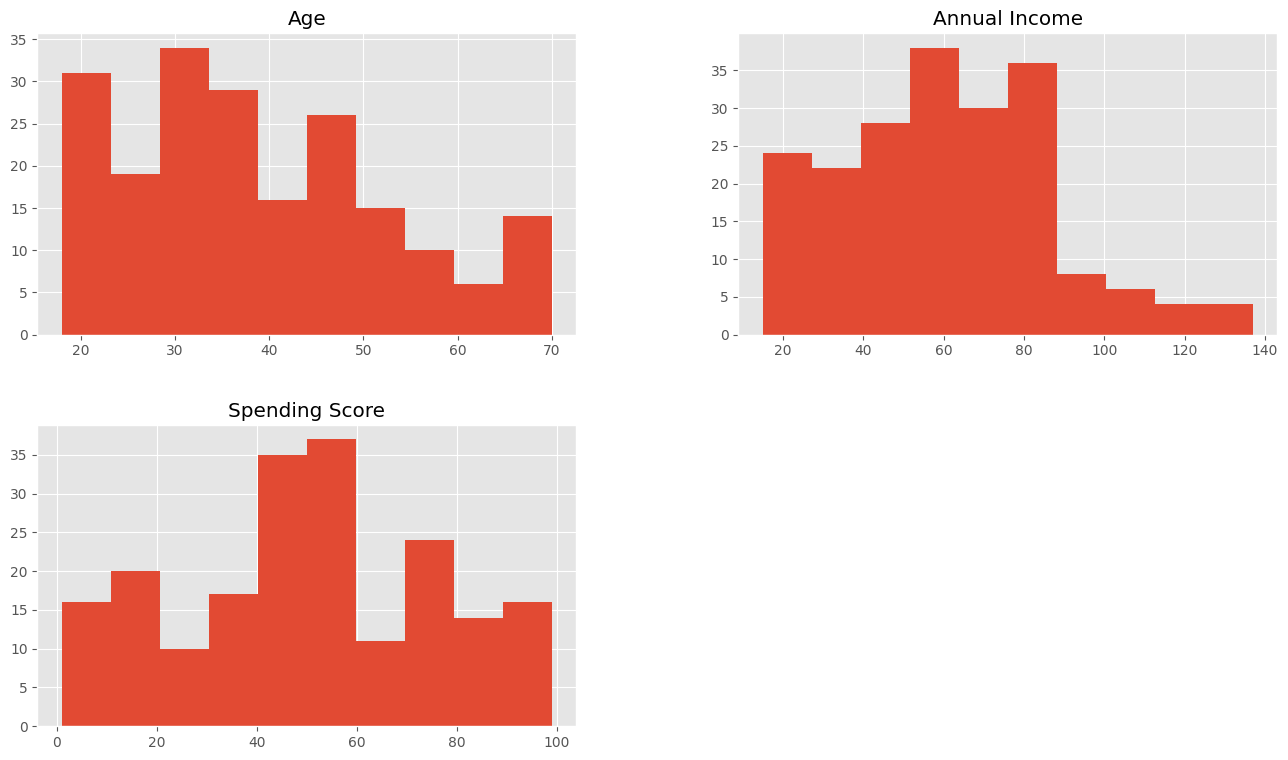

In [277]:
# Mostramos la distribución de los datos
df.drop('CustomerID', axis = 1).hist()
plt.show()

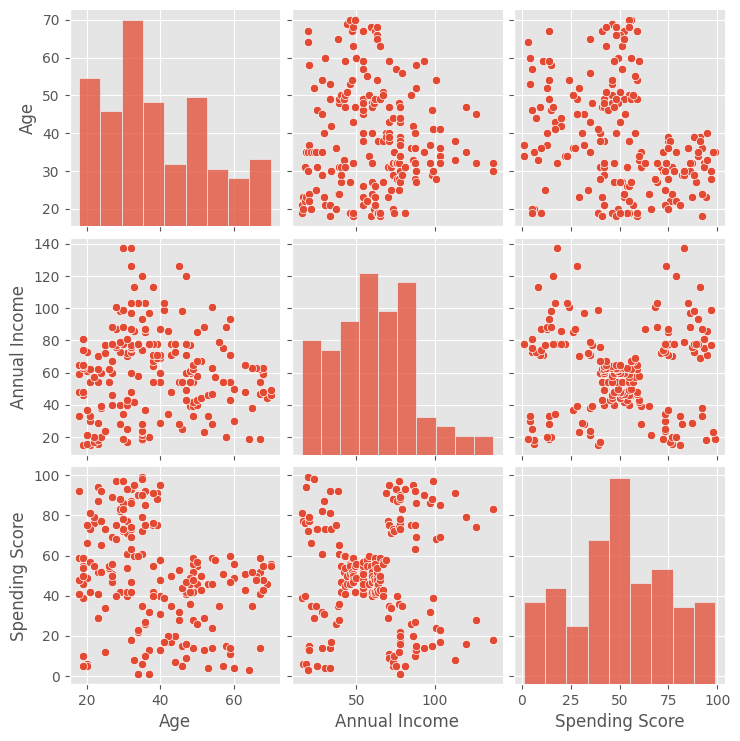

In [278]:
# Mostramos las relaciones entre los datos
sb.pairplot(df.drop('CustomerID', axis = 1), height = 2.5)

# Tratamiento previo de los datos

- Quitar la columna de ID
- Quitar la columna de género
- Quitar los outliers
- Normalizar

In [279]:
# Quitamos la columna de ID
df = df.drop('CustomerID', axis = 1)
# Quitamos la columna de género
df = df.drop('Genre', axis = 1)
# Mostramos los datos
df.head()

,Age,Annual Income,Spending Score
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


Text(0.5, 1.0, 'Boxplot de las variables')

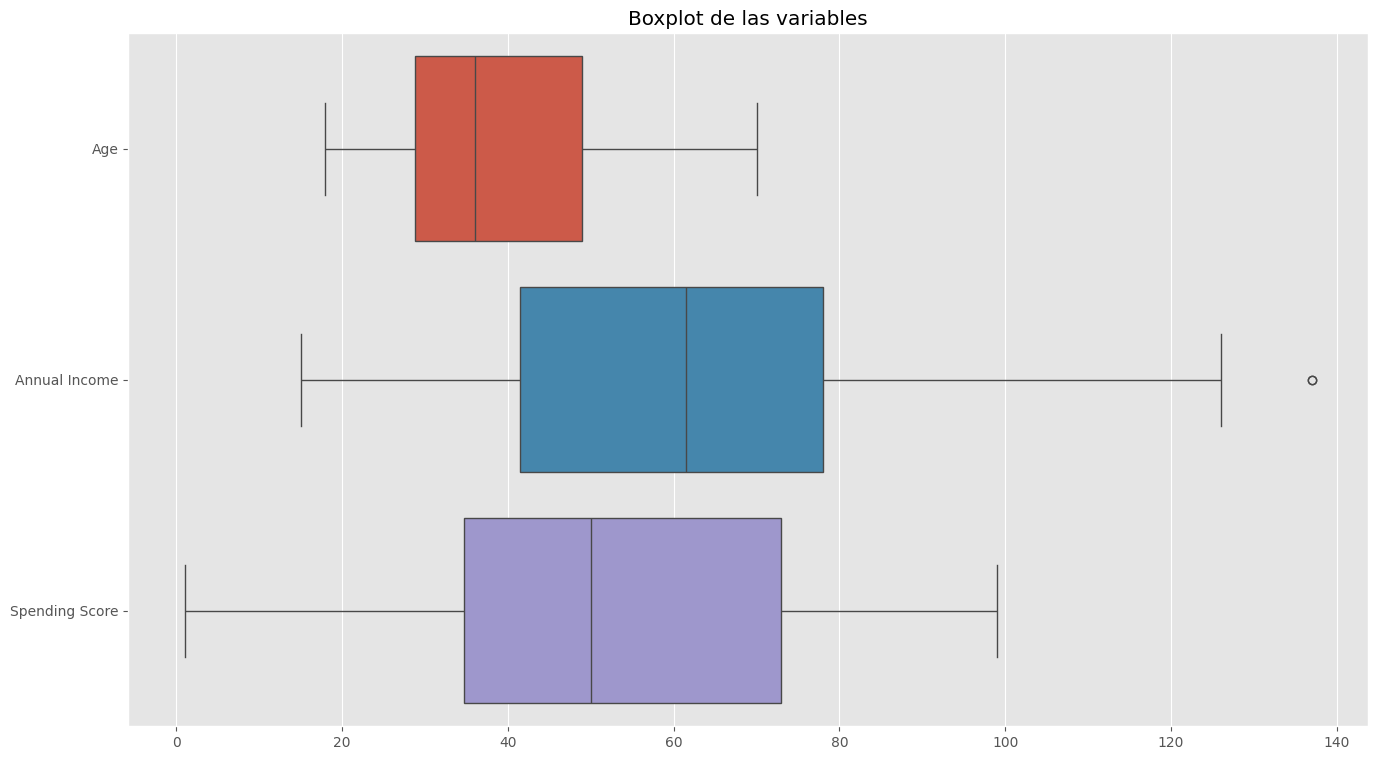

In [280]:
# Comprobamos si existen outliers
sb.boxplot(data = df, orient = 'h').set_title("Boxplot de las variables")

In [281]:
# Detectamos el outlier de Annual Income
df[df['Annual Income'] > 135]

,Age,Annual Income,Spending Score
198,32,137,18
199,30,137,83


In [282]:
# Quitamos los outliers, pues son ruido
# df = df[df['Annual Income'] < 135]
df.head()

,Age,Annual Income,Spending Score
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


In [283]:
# ------------------ Normalización

# df = (df - df.min()) / (df.max() - df.min())
# df.head()

# ------------------ Estandarización

df_mean = df.mean()
df_std = df.std()
df = (df - df_mean) / df_std
df.head()

,Age,Annual Income,Spending Score
0,-1.421003,-1.734646,-0.433713
1,-1.277829,-1.734646,1.192711
2,-1.349416,-1.696572,-1.711618
3,-1.134655,-1.696572,1.037814
4,-0.561958,-1.658498,-0.394989


# Agrupamiento de los datos

In [284]:
import plotly.express as px
fig = px.scatter_3d(df, x = 'Age', y = 'Annual Income', z = 'Spending Score')
fig.show()

## K-Means

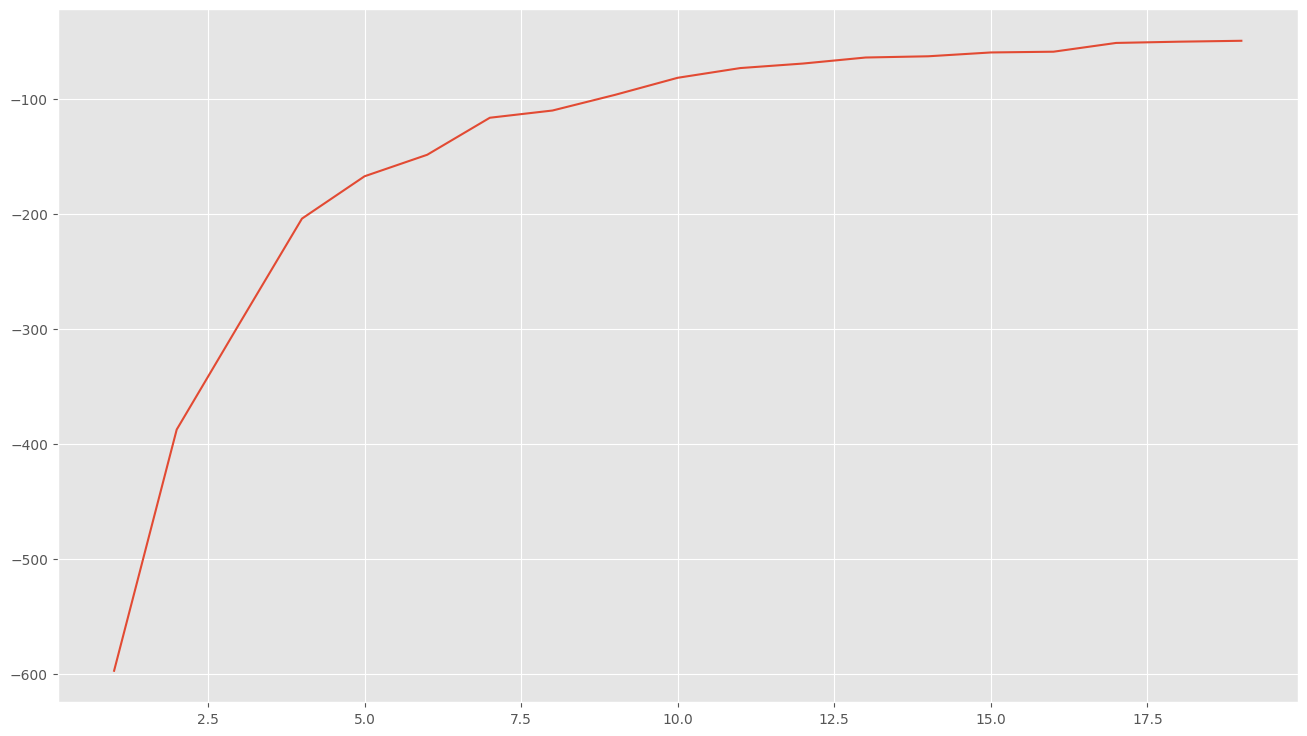

In [285]:
# Definimos el rango donde vamos a probar kmeans
Nc = range(1, 20)
kmeans = [KMeans(n_clusters = i) for i in Nc]
kmeans
score = [kmeans[i].fit(df).score(df) for i in range(len(kmeans))]
score
# Mostramos 'el codo'
plt.plot(Nc, score)

In [286]:
# Elegimos 6 clusters
kmeans = KMeans(n_clusters = 6).fit(df)
centroids = kmeans.cluster_centers_
print(centroids)

[[-0.41878423  2.0618641   1.09313407]
 [ 1.20182469 -0.2351832  -0.05223672]
 [-0.42963075  0.7413101   1.23847625]
 [-0.97822376 -0.74119985  0.46627028]
 [ 0.07314728  0.97250467 -1.19429976]
 [ 0.52974416 -1.28727809 -1.23337167]]


In [287]:
# Mostramos los clusters con datos comprensibles
# Deshacemos la estandarización
for each in centroids:
  print(each * df_std + df_mean)

Age                33.000000
Annual Income     114.714286
Spending Score     78.428571
dtype: float64
Age               55.638298
Annual Income     54.382979
Spending Score    48.851064
dtype: float64
Age               32.848485
Annual Income     80.030303
Spending Score    82.181818
dtype: float64
Age               25.185185
Annual Income     41.092593
Spending Score    62.240741
dtype: float64
Age               39.871795
Annual Income     86.102564
Spending Score    19.358974
dtype: float64
Age               46.25
Annual Income     26.75
Spending Score    18.35
dtype: float64


In [288]:
# Mostramos los grupos en un gráfico 3D
import plotly.graph_objects as go

# Columna auxiliar
df['Cluster_kmeans'] = kmeans.fit_predict(df[['Age', 'Annual Income', 'Spending Score']])

# Define los colores para cada cluster
colores = ['blue', 'red', 'green', 'cyan', 'purple', 'yellow']

fig = go.Figure()

# Scatter plot para cada cluster
for i in df['Cluster_kmeans'].unique():
  df_cluster = df[df['Cluster_kmeans'] == i]
  fig.add_trace(go.Scatter3d(
    x = df_cluster['Age'], 
    y = df_cluster['Annual Income'], 
    z = df_cluster['Spending Score'], 
    mode = 'markers',
    marker = dict(
      size = 3,
      color = colores[i],
      opacity = 0.8
    ),
    name = 'Cluster ' + str(i)
  ))

fig.show()

## Dendogramas

### Método single

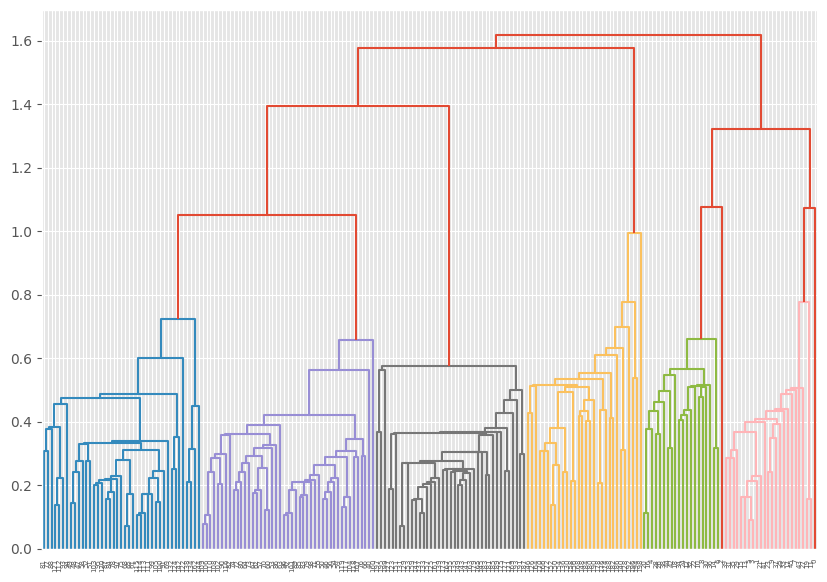

In [289]:
# Dendograma con el método single
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Realiza el agrupamiento jerárquico con el método 'single'
linked = linkage(df, 'single')

# Crea el dendrograma
plt.figure(figsize = (10, 7))
dendrogram(linked,
           orientation = 'top',
           labels = df.index,
           distance_sort = 'descending',
           show_leaf_counts = True,
           color_threshold = 1)  # Ajusta este valor según tus necesidades
plt.show()

In [290]:
# Calidad del dendograma
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

# Calcula el coeficiente cophenético
c, coph_dists = cophenet(linked, pdist(df))

print(c)

0.8128947732343952


In [291]:
from scipy.cluster.hierarchy import fcluster

# Define el número de clusters 
num_clusters = 6

# Añade los clusters a tu DataFrame
df['Cluster_single'] = fcluster(linked, num_clusters, criterion='maxclust')

# Define los colores para cada cluster
colores = ['blue', 'red', 'green', 'cyan', 'purple', 'yellow']

fig = go.Figure()

# Scatter plot para cada cluster
for i in df['Cluster_single'].unique():
  df_cluster = df[df['Cluster_single'] == i]
  fig.add_trace(go.Scatter3d(
    x = df_cluster['Age'], 
    y = df_cluster['Annual Income'], 
    z = df_cluster['Spending Score'], 
    mode = 'markers',
    marker = dict(
      size = 3,
      color = colores[i % len(colores)],
      opacity = 0.8
    ),
    name = 'Cluster ' + str(i)
  ))

fig.show()

### Método centroid

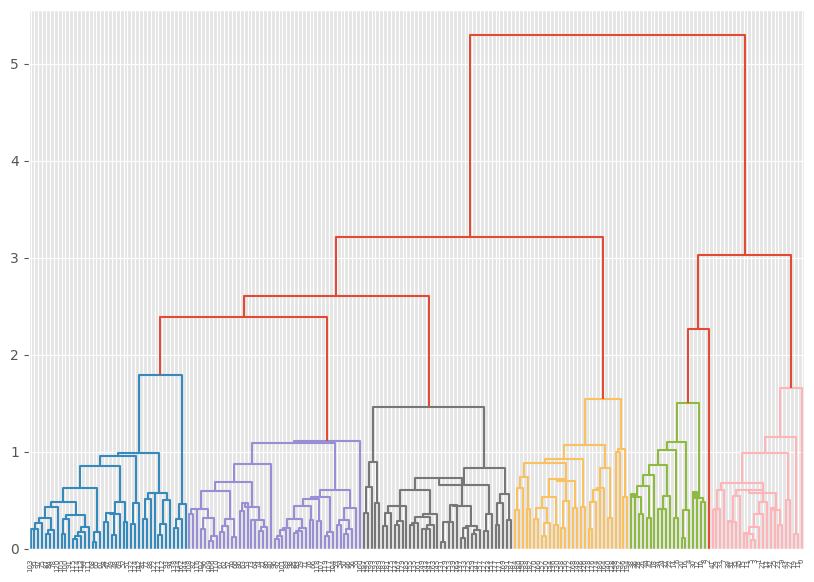

In [292]:
# Dendograma con el método centroid

# Realiza el agrupamiento jerárquico con el método 'centroid'
linked = linkage(df, 'centroid')

# Crea el dendrograma
plt.figure(figsize = (10, 7))
dendrogram(linked,
           orientation = 'top',
           labels = df.index,
           distance_sort = 'descending',
           show_leaf_counts = True,
           color_threshold=2)
plt.show()

In [293]:
# Calcula el coeficiente cophenético
c, coph_dists = cophenet(linked, pdist(df))
print(c)

0.9072295108818598


In [294]:
from scipy.cluster.hierarchy import fcluster

# Define el número de clusters 
num_clusters = 6

# Añade los clusters a tu DataFrame
df['Cluster_centroid'] = fcluster(linked, num_clusters, criterion='maxclust')

# Define los colores para cada cluster
colores = ['blue', 'red', 'green', 'cyan', 'purple', 'yellow']

fig = go.Figure()

# Scatter plot para cada cluster
for i in df['Cluster_centroid'].unique():
  df_cluster = df[df['Cluster_centroid'] == i]
  fig.add_trace(go.Scatter3d(
    x = df_cluster['Age'], 
    y = df_cluster['Annual Income'], 
    z = df_cluster['Spending Score'], 
    mode = 'markers',
    marker = dict(
      size = 3,
      color = colores[i % len(colores)],
      opacity = 0.8
    ),
    name = 'Cluster ' + str(i)
  ))

fig.show()

### Método ward

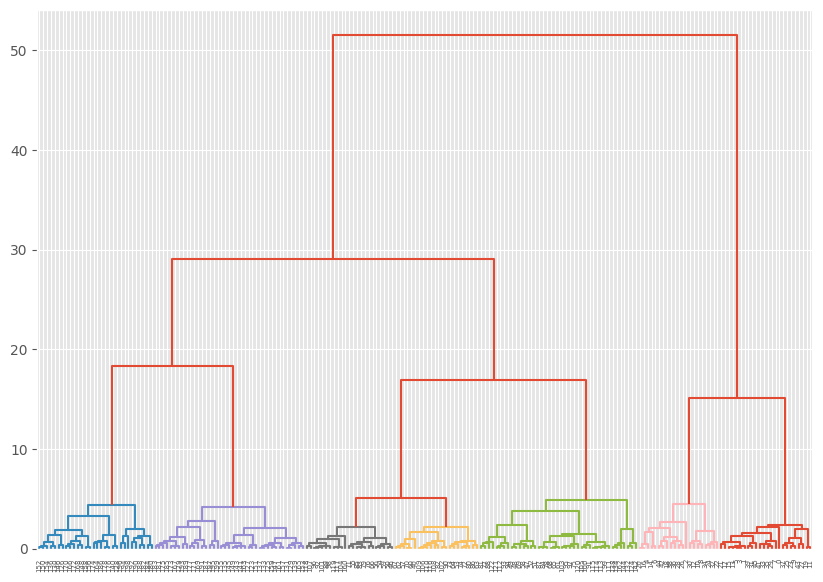

In [295]:
# Dendograma con el método ward

# Realiza el agrupamiento jerárquico con el método 'ward'
linked = linkage(df, 'ward')

# Crea el dendrograma
plt.figure(figsize = (10, 7))
dendrogram(linked,
           orientation = 'top',
           labels = df.index,
           distance_sort = 'descending',
           show_leaf_counts = True,
           color_threshold=5)
plt.show()

In [296]:
# Calcula el coeficiente cophenético
c, coph_dists = cophenet(linked, pdist(df))

print(c)

0.8825635186861862


In [297]:
from scipy.cluster.hierarchy import fcluster

# Define el número de clusters 
num_clusters = 6

# Añade los clusters a tu DataFrame
df['Cluster_ward'] = fcluster(linked, num_clusters, criterion='maxclust')

# Define los colores para cada cluster
colores = ['blue', 'red', 'green', 'cyan', 'purple', 'yellow']

fig = go.Figure()

# Scatter plot para cada cluster
for i in df['Cluster_ward'].unique():
  df_cluster = df[df['Cluster_ward'] == i]
  fig.add_trace(go.Scatter3d(
    x = df_cluster['Age'], 
    y = df_cluster['Annual Income'], 
    z = df_cluster['Spending Score'], 
    mode = 'markers',
    marker = dict(
      size = 3,
      color = colores[i % len(colores)],
      opacity = 0.8
    ),
    name = 'Cluster ' + str(i)
  ))

fig.show()

# Agrupamiento por género

In [298]:
# Cargamos la base de datos
df = pd.read_csv(r"analisis.csv")
# Quitamos CustomerID
df = df.drop('CustomerID', axis = 1)
df.head()

,Genre,Age,Annual Income,Spending Score
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [299]:
# Creamos dos df, uno para cada género
df_female = df[df['Genre'] == 'Female']
df_female = df_female.drop('Genre', axis = 1)
df_male = df[df['Genre'] == 'Male']
df_male = df_male.drop('Genre', axis = 1)

In [300]:
# Quitamos los outliers
# df_female = df_female[df_female['Annual Income'] < 135]
# df_male = df_male[df_male['Annual Income'] < 135]

# ------------------ Estandarización female
df_female_mean = df_female.mean()
df_female_std = df_female.std()
df_female = (df_female - df_female_mean) / df_female_std

# ---------------- Estandarización male
df_male_mean = df_male.mean()
df_male_std = df_male.std()
df_male = (df_male - df_male_mean) / df_male_std

In [301]:
# Elegimos 6 clusters
kmeans_female = KMeans(n_clusters = 6).fit(df_female)
centroids_female = kmeans_female.cluster_centers_

# Deshacemos la estandarización
for each in centroids_female:
  print(each * df_female_std + df_female_mean)

Age               25.857143
Annual Income     26.642857
Spending Score    79.142857
dtype: float64
Age               27.833333
Annual Income     58.125000
Spending Score    46.541667
dtype: float64
Age               43.785714
Annual Income     93.285714
Spending Score    20.642857
dtype: float64
Age               32.190476
Annual Income     86.047619
Spending Score    81.666667
dtype: float64
Age               54.153846
Annual Income     54.230769
Spending Score    48.961538
dtype: float64
Age               41.538462
Annual Income     26.538462
Spending Score    20.692308
dtype: float64


In [302]:
# Mostramos los grupos en un gráfico 3D
import plotly.graph_objects as go

# Columna auxiliar
df_female['Cluster_female'] = kmeans.fit_predict(df_female[['Age', 'Annual Income', 'Spending Score']])

# Define los colores para cada cluster
colores = ['blue', 'red', 'green', 'cyan', 'purple', 'yellow']

fig_female = go.Figure()

# Scatter plot para cada cluster
for i in df_female['Cluster_female'].unique():
  df_cluster = df_female[df_female['Cluster_female'] == i]
  fig_female.add_trace(go.Scatter3d(
    x = df_cluster['Age'], 
    y = df_cluster['Annual Income'], 
    z = df_cluster['Spending Score'], 
    mode = 'markers',
    marker = dict(
      size = 3,
      color = colores[i],
      opacity = 0.8
    ),
    name = 'Cluster ' + str(i)
  ))

# Añade los centroides al gráfico
fig_female.add_trace(go.Scatter3d(
  x = centroids_female[:, 0], 
  y = centroids_female[:, 1], 
  z = centroids_female[:, 2], 
  mode = 'markers',
  marker = dict(
    size = 5,
    color = 'black',                
    opacity = 0.8
  ),
  name = 'Centroids'
))

fig_female.show()

In [303]:
# Elegimos 6 clusters
kmeans_male = KMeans(n_clusters = 6).fit(df_male)
centroids_male = kmeans_male.cluster_centers_

# Deshacemos la estandarización
for each in centroids_male:
  print(each * df_male_std + df_male_mean)

Age                30.00
Annual Income     115.75
Spending Score     80.50
dtype: float64
Age               58.846154
Annual Income     48.692308
Spending Score    39.846154
dtype: float64
Age               34.214286
Annual Income     78.928571
Spending Score    83.285714
dtype: float64
Age               38.473684
Annual Income     85.894737
Spending Score    14.210526
dtype: float64
Age               24.500000
Annual Income     56.416667
Spending Score    52.416667
dtype: float64
Age               26.846154
Annual Income     25.615385
Spending Score    65.076923
dtype: float64


In [304]:
# Mostramos los grupos en un gráfico 3D
import plotly.graph_objects as go

# Columna auxiliar
df_male['Cluster_male'] = kmeans.fit_predict(df_male[['Age', 'Annual Income', 'Spending Score']])

# Define los colores para cada cluster
colores = ['blue', 'red', 'green', 'cyan', 'purple', 'yellow']

fig_male = go.Figure()

# Scatter plot para cada cluster
for i in df_male['Cluster_male'].unique():
  df_cluster = df_male[df_male['Cluster_male'] == i]
  fig_male.add_trace(go.Scatter3d(
    x = df_cluster['Age'], 
    y = df_cluster['Annual Income'], 
    z = df_cluster['Spending Score'], 
    mode = 'markers',
    marker = dict(
      size = 3,
      color = colores[i],
      opacity = 0.8
    ),
    name = 'Cluster ' + str(i)
  ))

# Añade los centroides al gráfico
fig_male.add_trace(go.Scatter3d(
  x = centroids_male[:, 0], 
  y = centroids_male[:, 1], 
  z = centroids_male[:, 2], 
  mode = 'markers',
  marker = dict(
    size = 5,
    color = 'black',                
    opacity = 0.8
  ),
  name = 'Centroids'
))

fig_male.show()